## GAN (Generative Adversarial Networks)  
- Two models are trained simultaneously by an adversarial process  
- A "generator" ("the artist") learns to create images that look real, while  
- a "discriminator" ("the art critic") learns to tell real images apart from fakes  

* The process reaches equilibrium when the discriminator can NO LONGER DISTINGUISH real images from fakes

### Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

print(tf.__version__)

2.0.0


In [2]:
# To generate GIFs
!pip install -q imageio

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare dataset

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and Shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create the models : _both "generator" and "discriminator" are defined using `keras Sequential API`_

### The Generator  
- The "generator" uses `tf.keras.layers.Conc2DTranspose` layers to produce an image from a seed  

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

#### Use the "generator" _as yet untrained_ to create an image

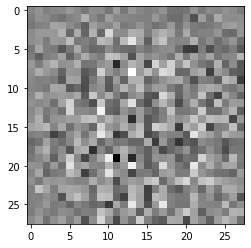

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator  
- The "discriminator" is a CNN-based image classifier

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

#### Use the "discriminator" _as yet untrained_ to classify the generated images as _real_ or _fake_  
- The model will be trained to output (+) values for real images, and (-) values for fake images

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[-0.00265038]], shape=(1, 1), dtype=float32)


### Define the loss and optimizers _for both models_

In [16]:
# This method returns a helper function to compute cross entropy loss 

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss  
- quantifies how well the discriminator is able to distinguish real images from fakes  
- it compares the discriminator's predictions on real images to an array of `1`s  
- and the discriminator's predictions on fake (generated) images to an array of `0`s

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss  
- quantifies how well it was able to trick the discriminator  
- if the "generator" is performing well, the "discriminator" will classify the fake images as real(or `1`)  
- we will compare the discriminators decisions on the generated images to an array of `1`s 

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Optimizers of the _discriminator_ and the _generator_ are different since we will train two networks separately 

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Save checkpoints

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

### Define training loop

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# we will reuse this seed overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# Notice: the annotaion `tf.function` causes the function to be "compiled"
# @ annotate "decorator" and it makes "optimized"

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

#### Generate and Save images

In [27]:
def generate_and_save_images(model, epoch, test_input):
    # Notice: 'training' is set to False
    # This is so all layers run in inference mode (batchnorm)
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Train the model

#### Call `train()` method defined above to train the "generator" and "discriminator" simultaneously

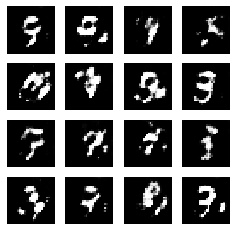

Time for epoch 10 is 164.6286027431488 sec


In [ ]:
train(train_dataset, EPOCHS)

#### Restore the latest checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Create a `GIF`

In [ ]:
# Display a single image using the epoch number 

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

#### Use `imageio` to create an animated `.gif` using the images saved during training

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            contimue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

end -

#### _Reference_ 
https://www.tensorflow.org/tutorials/generative/dcgan 